#  Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




##  Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import warnings
warnings.filterwarnings("ignore")



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

##  Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\risha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"aren't", 'just', 'then', 'himself', 'down', 'under', 'haven', 'from', 'll', 're', 'he', 'him', "she's", 'won', 'if', 'what', 'o', 'am', 'm', "you've", 'any', 'so', 'i', 't', 'below', 'needn', "you'd", 'she', 'aren', 'didn', 'only', 'again', 'other', 'do', "mightn't", 'or', 'both', 'them', 'shan', "that'll", 'mustn', "hasn't", 'who', 'for', 'has', "mustn't", 'this', 'wouldn', 'themselves', 'y', "weren't", 'weren', 'isn', "shouldn't", 'once', 'we', 'our', "needn't", 'hers', 'a', 'her', 'nor', "wouldn't", 'd', 'no', 'too', 'not', "hadn't", 'with', 'ourselves', 'their', 'as', 'because', 'about', 'some', 'why', 've', 'yourself', 'here', 'herself', 'until', 'through', 'been', 'in', 'where', 'into', 'will', 'had', "wasn't", 'mightn', "couldn't", 'you', 'now', 'between', "should've", 'ain', 'doing', 'own', 'these', 'on', 'all', 'above', 'were', 'hasn', 'most', 'against', 'wasn', 'very', 'to', 'yours', 'the', 'are', 's', "isn't", 'ma', 'theirs', 'couldn', 'how', 'me', 'itself', 'before', 'aft

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [15]:

# storing final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

#  Bag of Words (BoW)

In [16]:
#BoW
count_vect = CountVectorizer() #in scikit-learn

final_counts = count_vect.fit_transform(final['Text'].iloc[0:1000].values) #Taking the top 1k datapoints


In [17]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [18]:
final_counts.get_shape()

(1000, 7109)

##  Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [19]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [20]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['Text'].values)


In [21]:
final_bigram_counts.get_shape()

(364171, 2910192)

# TF-IDF

In [19]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))


#Sampling 1000 datapoints randomly
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].iloc[0:1000].values)#Taking the top 1k datapoints


In [20]:
print(final_tf_idf.get_shape())
print(type(final_tf_idf))


(1000, 52885)
<class 'scipy.sparse.csr.csr_matrix'>


In [21]:
features = tf_idf_vect.get_feature_names()
len(features)


52885

In [25]:
features[100000:100010]


['ales until',
 'ales ve',
 'ales would',
 'ales you',
 'alessandra',
 'alessandra ambrosia',
 'alessi',
 'alessi added',
 'alessi also',
 'alessi and']

In [26]:
# covnert a row in saprsematrix to a numpy array
print(final_tf_idf[3,:].toarray()[0]) 


[0. 0. 0. ... 0. 0. 0.]


In [27]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [28]:
top_tfidf


,feature,tfidf
0,sendak books,0.173437
1,rosie movie,0.173437
2,paperbacks seem,0.173437
3,cover version,0.173437
4,these sendak,0.173437
5,the paperbacks,0.173437
6,pages open,0.173437
7,really rosie,0.168074
8,incorporates them,0.168074
9,paperbacks,0.168074


#  Word2Vec

In [7]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)



In [129]:
model.wv['computer']


array([  1.07421875e-01,  -2.01171875e-01,   1.23046875e-01,
         2.11914062e-01,  -9.13085938e-02,   2.16796875e-01,
        -1.31835938e-01,   8.30078125e-02,   2.02148438e-01,
         4.78515625e-02,   3.66210938e-02,  -2.45361328e-02,
         2.39257812e-02,  -1.60156250e-01,  -2.61230469e-02,
         9.71679688e-02,  -6.34765625e-02,   1.84570312e-01,
         1.70898438e-01,  -1.63085938e-01,  -1.09375000e-01,
         1.49414062e-01,  -4.65393066e-04,   9.61914062e-02,
         1.68945312e-01,   2.60925293e-03,   8.93554688e-02,
         6.49414062e-02,   3.56445312e-02,  -6.93359375e-02,
        -1.46484375e-01,  -1.21093750e-01,  -2.27539062e-01,
         2.45361328e-02,  -1.24511719e-01,  -3.18359375e-01,
        -2.20703125e-01,   1.30859375e-01,   3.66210938e-02,
        -3.63769531e-02,  -1.13281250e-01,   1.95312500e-01,
         9.76562500e-02,   1.26953125e-01,   6.59179688e-02,
         6.93359375e-02,   1.02539062e-02,   1.75781250e-01,
        -1.68945312e-01,

In [12]:
model.wv.similarity('woman', 'man')

0.76640122309953518

In [131]:
model.wv.most_similar('woman')

[('man', 0.7664012312889099),
 ('girl', 0.7494641542434692),
 ('teenage_girl', 0.7336830496788025),
 ('teenager', 0.6317086219787598),
 ('lady', 0.6288787126541138),
 ('teenaged_girl', 0.6141784191131592),
 ('mother', 0.607630729675293),
 ('policewoman', 0.6069462299346924),
 ('boy', 0.5975908041000366),
 ('Woman', 0.5770982503890991)]

In [14]:
model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

KeyError: "word 'tasti' not in vocabulary"

In [155]:
model.wv.most_similar('tasty') 


[('delicious', 0.8730389475822449),
 ('scrumptious', 0.8007042407989502),
 ('yummy', 0.7856923341751099),
 ('flavorful', 0.7420164346694946),
 ('delectable', 0.7385422587394714),
 ('juicy_flavorful', 0.7114803791046143),
 ('appetizing', 0.701721727848053),
 ('crunchy_salty', 0.7012301087379456),
 ('flavourful', 0.6912214159965515),
 ('flavoursome', 0.6857703328132629)]

In [137]:
model.wv.similarity('tasty', 'tast')


0.44035054190088901

In [22]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].iloc[0:1000].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [23]:
print(final['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
*****************************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is'

In [24]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    


In [25]:
#Fetching the trained word vectors from the model
w2v_matrix=w2v_model.wv
print(w2v_matrix)


In [26]:
#w2v_model.wv.most_similar('like')

In [26]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
count_vect_feat.index('like')
print(count_vect_feat[64055])

NameError: name 'count_vect' is not defined

#  Avg W2V, TFIDF-W2V

In [27]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

1000
50


In [28]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

    

# t-SNE Visualization of BoW

In [29]:
#Standardizing the data 
from sklearn.preprocessing import StandardScaler
standardized_data=StandardScaler(with_mean=False).fit_transform(final_counts)

#Dimesion of the standardized_data
print(standardized_data.shape)

(1000, 7109)


In [30]:
from sklearn.manifold import TSNE

#Using the first 1k datapoints


#Converting the sparse matrix to numpy array
data_array=standardized_data.toarray()
labels_1k=final['Score'].iloc[0:1000].values
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne_data1=model.fit_transform(data_array)
tsne_data1 = np.vstack((tsne_data1.T, labels_1k)).T



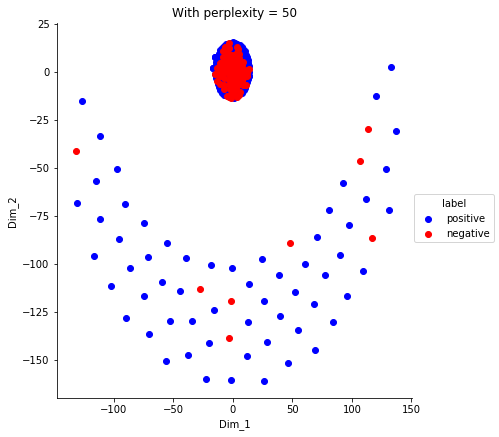

In [31]:
# creating a new data fram which help us in ploting the result data
import seaborn as sns
tsne_df = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", palette=['blue','red'],size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()




# t-SNE visualization of tf-idf

In [33]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
standardized_data_tf_idf=StandardScaler(with_mean=False).fit_transform(final_tf_idf)

#Printing the shape
print(standardized_data_tf_idf.shape)

(1000, 52885)


In [34]:
from sklearn.manifold import TSNE


#Converting the sparse matrix to numpy array
tfidf_data_array=standardized_data_tf_idf.toarray()
labels_1k=final['Score'].iloc[0:1000].values
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne_data2=model.fit_transform(tfidf_data_array)
tsne_data2 = np.vstack((tsne_data2.T, labels_1k)).T


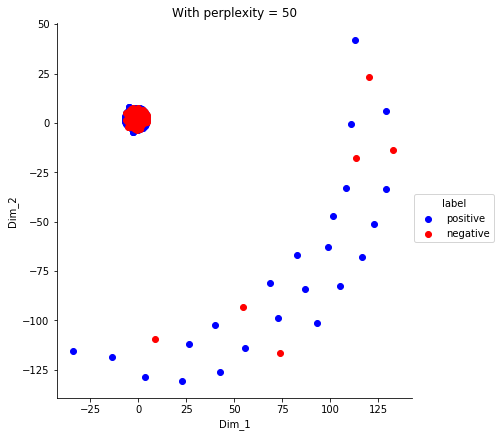

In [35]:
# creating a new data fram which help us in ploting the result data
import seaborn as sns
tsne_df2 = pd.DataFrame(data=tsne_data2, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df2, hue="label", palette=['blue','red'],size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()


# tSNE  visualization of Avg-W2V

In [36]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
standardized_data_w2v=StandardScaler(with_mean=False).fit_transform(sent_vectors)

#Printing the shape
print(standardized_data_w2v.shape)
print(type(standardized_data_w2v))

(1000, 50)
<class 'numpy.ndarray'>


In [37]:
from sklearn.manifold import TSNE

labels_1k=final['Score'].iloc[0:1000].values
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne_data_w2v=model.fit_transform(standardized_data_w2v)
tsne_data_w2v = np.vstack((tsne_data_w2v.T, labels_1k)).T

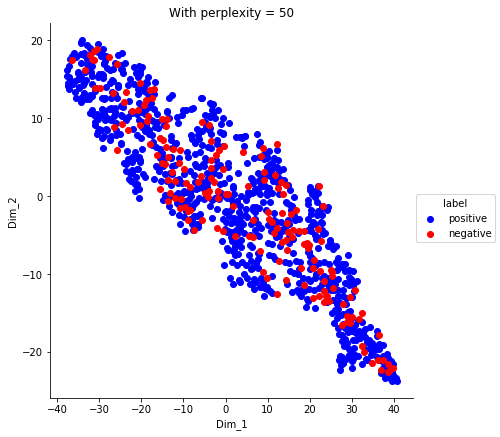

In [38]:
# creating a new data fram which help us in ploting the result data
import seaborn as sns
tsne_df_w2v = pd.DataFrame(data=tsne_data_w2v, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df_w2v, hue="label", palette=['blue','red'],size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()


# tSNE visualization of tfidf-w2v

In [39]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
standardized_data_tfidfw2v=StandardScaler().fit_transform(tfidf_sent_vectors)

#Printing the shape
print(standardized_data_tfidfw2v.shape)
print(type(standardized_data_tfidfw2v))

(1000, 50)
<class 'numpy.ndarray'>


In [40]:
from sklearn.manifold import TSNE

labels_1k=final['Score'].iloc[0:1000].values
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne_data_tfidfw2v=model.fit_transform(standardized_data_tfidfw2v)
tsne_data_tfidfw2v = np.vstack((tsne_data_tfidfw2v.T, labels_1k)).T

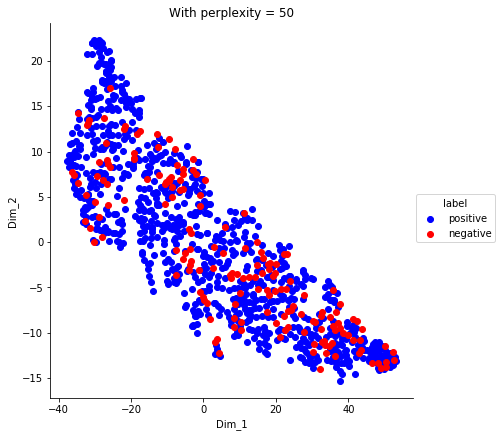

In [41]:
# creating a new data fram which help us in ploting the result data
import seaborn as sns
tsne_df_tfidfw2v = pd.DataFrame(data=tsne_data_tfidfw2v, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df_tfidfw2v, hue="label", palette=['blue','red'],size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()
